In [29]:
!pip install --quiet pyarrow fastparquet tqdm seaborn


In [30]:
import os, json, math, random, gc, glob
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Paths
BASE = Path("/kaggle/input/dataset")
ECRCD_DIR = BASE / "extcrcd" / "ECRCD"
META_PATH = BASE / "metadata" / "metadata.json"
WORK_DIR = Path("/kaggle/working"); WORK_DIR.mkdir(exist_ok=True, parents=True)


Device: cuda


In [31]:

import os, glob, json
from pathlib import Path
import pyarrow.parquet as pq
import pandas as pd
from tqdm import tqdm

SEED = 42

SEARCH_ROOTS = [Path("/kaggle/input/dataset"),
                Path("/kaggle/input"),
                Path.cwd()]

def autodiscover_ecrcd():
    found_parquets = []
    for root in SEARCH_ROOTS:
        if not root.exists(): 
            continue
        patt = str(root / "**" / "train-*.parquet")
        for p in glob.glob(patt, recursive=True):
            p = Path(p)
            s = str(p).lower()
            if ("ecrcd" in s) or ("extcrcd" in s):
                found_parquets.append(p)

    found_parquets = sorted(set(found_parquets))
    if not found_parquets:
        raise FileNotFoundError("Couldn't find any 'train-*.parquet' under likely roots.")

    ecrcd_candidates = []
    for p in found_parquets:
        parts = [q for q in p.parts]
        if "ECRCD" in parts:
            idx = parts.index("ECRCD")
            ecrcd_candidates.append(Path(*parts[:idx+1]))
        else:
            ecrcd_candidates.append(p.parents[2])

    from collections import Counter
    cnt = Counter(ecrcd_candidates)
    ecrcd_dir, _ = cnt.most_common(1)[0]

    meta_candidates = [
        ecrcd_dir.parent / "metadata" / "metadata.json",
        ecrcd_dir / "metadata.json",
        ecrcd_dir.parent.parent / "metadata" / "metadata.json",
    ]
    meta_path = None
    for mp in meta_candidates:
        if mp.exists():
            meta_path = mp
            break

    return ecrcd_dir, meta_path, found_parquets

ECRCD_DIR, META_PATH, PARQUET_FILES = autodiscover_ecrcd()

print("📁 ECRCD_DIR =", ECRCD_DIR)
print("📄 metadata.json =", META_PATH if META_PATH else "not found")
print(f"📦 Parquet chunks found: {len(PARQUET_FILES)}")
for p in PARQUET_FILES[:5]:
    print("  •", p)


wanted_cols = [
    "video_id", "frame_n", "timestamp",
    "/ECM/custom/local/setpoint_cp", "/ECM/custom/setpoint_cp", "/ECM/measured_js",
    "/MTML/gripper/measured_js", "/MTML/measured_cp", "/MTML/measured_js",
    "/MTMR/gripper/measured_js", "/MTMR/measured_cp", "/MTMR/measured_js",
    "/PSM1/jaw/measured_js", "/PSM1/measured_js",
    "/PSM2/jaw/measured_js", "/PSM2/measured_js",
    "/pedals/camera", "/pedals/clutch", "/pedals/monopolar"
]

def read_chunk(path: Path, columns):
    sch = pq.read_schema(path)
    cols_available = set(sch.names)
    cols = [c for c in columns if c in cols_available]
    table = pq.read_table(path, columns=cols)
    return table.to_pandas()

def load_ecrcd_from_list(files, max_files=None, frac: float = 1.0):
    files = sorted(files)
    if max_files:
        files = files[:max_files]
    dfs = []
    for p in tqdm(files, desc="Reading parquet"):
        df = read_chunk(p, wanted_cols)
        if frac < 1.0 and len(df):
            df = df.sample(frac=frac, random_state=SEED).sort_values(["video_id","frame_n"])
        dfs.append(df)
    if not dfs:
        raise ValueError("No objects to concatenate (no frames read).")
    out = pd.concat(dfs, ignore_index=True)
    out = out.sort_values(["video_id","frame_n"]).reset_index(drop=True)
    return out

df_raw = load_ecrcd_from_list(PARQUET_FILES, max_files=10, frac=0.5)
print("✅ Loaded shape:", df_raw.shape)
df_raw.head()


📁 ECRCD_DIR = /kaggle/input/extcrcd/ECRCD
📄 metadata.json = /kaggle/input/metadata/metadata.json
📦 Parquet chunks found: 52
  • /kaggle/input/extcrcd/ECRCD/A_1/train-00000-of-00002 (1).parquet
  • /kaggle/input/extcrcd/ECRCD/A_1/train-00000-of-00002.parquet
  • /kaggle/input/extcrcd/ECRCD/B_1/train-00001-of-00002 (1).parquet
  • /kaggle/input/extcrcd/ECRCD/B_1/train-00001-of-00002.parquet
  • /kaggle/input/extcrcd/ECRCD/B_2/train-00000-of-00007.parquet


Reading parquet: 100%|██████████| 10/10 [00:00<00:00, 10.68it/s]

✅ Loaded shape: (35028, 19)


,video_id,frame_n,timestamp,/ECM/custom/local/setpoint_cp,/ECM/custom/setpoint_cp,/ECM/measured_js,/MTML/gripper/measured_js,/MTML/measured_cp,/MTML/measured_js,/MTMR/gripper/measured_js,/MTMR/measured_cp,/MTMR/measured_js,/PSM1/jaw/measured_js,/PSM1/measured_js,/PSM2/jaw/measured_js,/PSM2/measured_js,/pedals/camera,/pedals/clutch,/pedals/monopolar
0,A_1,0,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0331667352583294],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.0387599164783627],"[-0.17036104847310463, 0.017456879154860883, 0...","[-0.025366509232467062, 0.08836514701478106, -...",[0.4574224074221009],"[0.44956344880723137, -0.09631792440732809, 0....",[-0.2523724248432613],"[-0.43824964514649245, 0.13970423769472137, 0....",False,False,False
1,A_1,6,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0338223811080907],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.040278694642284],"[-0.17036104847310463, 0.017456879154860883, 0...","[-0.025366509232467062, 0.08836514701478106, -...",[0.4574224074221009],"[0.44956344880723137, -0.09631792440732809, 0....",[-0.2523724248432613],"[-0.4382573678793667, 0.1397119604275956, 0.05...",False,False,False
2,A_1,7,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0317243143888533],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.038844293043025],"[-0.17036104847310463, 0.017456879154860883, 0...","[-0.025366509232467062, 0.08836514701478106, -...",[0.4574224074221009],"[0.44956344880723137, -0.09631792440732809, 0....",[-0.2523724248432613],"[-0.4382573678793667, 0.1397119604275956, 0.05...",False,False,False
3,A_1,8,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0334289935982337],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.0394349289956608],"[-0.17036104847310463, 0.017456879154860883, 0...","[-0.025366509232467062, 0.08836514701478106, -...",[0.4574224074221009],"[0.44956344880723137, -0.09631792440732809, 0....",[-0.2523724248432613],"[-0.4382573678793667, 0.13970423769472137, 0.0...",False,False,False
4,A_1,12,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0318554435588059],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.0392661758663366],"[-0.17036104847310463, 0.017456879154860883, 0...","[-0.025366509232467062, 0.08836514701478106, -...",[0.4574224074221009],"[0.44956344880723137, -0.09631792440732809, 0....",[-0.2523724248432613],"[-0.43824964514649245, 0.1397119604275956, 0.0...",False,False,False


In [32]:

import numpy as np
import pandas as pd

ARRAY_COLS = {
    "ECM_js": "/ECM/measured_js",
    "MTML_js": "/MTML/measured_js",
    "MTMR_js": "/MTMR/measured_js",
    "PSM1_js": "/PSM1/measured_js",
    "PSM2_js": "/PSM2/measured_js",
    "MTML_grip": "/MTML/gripper/measured_js",
    "MTMR_grip": "/MTMR/gripper/measured_js",
    "PSM1_jaw": "/PSM1/jaw/measured_js",
    "PSM2_jaw": "/PSM2/jaw/measured_js",
}
CP_COLS = {
    "ECM_sp_local": "/ECM/custom/local/setpoint_cp",
    "ECM_sp": "/ECM/custom/setpoint_cp",
    "MTML_cp": "/MTML/measured_cp",
    "MTMR_cp": "/MTMR/measured_cp",
}
PEDALS = ["/pedals/camera", "/pedals/clutch", "/pedals/monopolar"]

def _arr_mean(x):
    try:
        a = np.asarray(x, dtype=float)
        return float(np.nanmean(a)) if a.size else np.nan
    except Exception:
        return np.nan

def _arr_std(x):
    try:
        a = np.asarray(x, dtype=float)
        return float(np.nanstd(a)) if a.size else np.nan
    except Exception:
        return np.nan

def _arr_norm_diff(a, b):
    try:
        a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
        n = min(a.size, b.size)
        if n == 0: return np.nan
        return float(np.linalg.norm(a[:n] - b[:n]))
    except Exception:
        return np.nan

def build_features(df: pd.DataFrame, fps: int = 25) -> pd.DataFrame:
    df = df.copy()

    for c in PEDALS:
        if c in df.columns:
            df[c] = df[c].astype(bool).astype(int)

    for name, col in ARRAY_COLS.items():
        if col in df.columns:
            df[f"{name}_mean"] = df[col].apply(_arr_mean)
            df[f"{name}_std"]  = df[col].apply(_arr_std)

    for name, col in CP_COLS.items():
        if col in df.columns:
            df[f"{name}_mean"] = df[col].apply(_arr_mean)
            df[f"{name}_std"]  = df[col].apply(_arr_std)

    df = df.sort_values(["video_id","frame_n"])
    grp = df.groupby("video_id", sort=False)

    for name, col in ARRAY_COLS.items():
        if col in df.columns:
            prev = grp[col].shift(1)
            df[f"{name}_speed"] = [_arr_norm_diff(a, b) for a, b in zip(df[col], prev)]

    for name, col in CP_COLS.items():
        if col in df.columns:
            prev = grp[col].shift(1)
            df[f"{name}_speed"] = [_arr_norm_diff(a, b) for a, b in zip(df[col], prev)]

    speed_cols = [c for c in df.columns if c.endswith("_speed")]
    df["speed_sum"] = df[speed_cols].sum(axis=1, min_count=1)
    df["speed_max"] = df[speed_cols].max(axis=1)

    def robust_z(x):
        med = np.nanmedian(x); mad = np.nanmedian(np.abs(x - med)) + 1e-9
        return (x - med) / (1.4826 * mad)

    df["speed_sum_z"] = grp["speed_sum"].transform(robust_z)
    df["speed_max_z"] = grp["speed_max"].transform(robust_z)

    df["speed_sum_diff"] = grp["speed_sum"].diff().fillna(0)
    df["speed_sum_diff_abs"] = df["speed_sum_diff"].abs()
    df["jerk_1s"] = grp["speed_sum_diff_abs"].transform(lambda x: x.rolling(fps, min_periods=1).mean())

    for name in ["MTML_grip_mean", "MTMR_grip_mean", "PSM1_jaw_mean", "PSM2_jaw_mean"]:
        if name in df.columns:
            d = df.groupby("video_id", sort=False)[name].diff()
            df[f"{name}_diff_abs"] = d.abs().fillna(0)

    return df.reset_index(drop=True)

df_feat = build_features(df_raw, fps=25)
print("✅ Feature shape:", df_feat.shape)
df_feat.head()


✅ Feature shape: (35028, 69)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,video_id,frame_n,timestamp,/ECM/custom/local/setpoint_cp,/ECM/custom/setpoint_cp,/ECM/measured_js,/MTML/gripper/measured_js,/MTML/measured_cp,/MTML/measured_js,/MTMR/gripper/measured_js,...,speed_max,speed_sum_z,speed_max_z,speed_sum_diff,speed_sum_diff_abs,jerk_1s,MTML_grip_mean_diff_abs,MTMR_grip_mean_diff_abs,PSM1_jaw_mean_diff_abs,PSM2_jaw_mean_diff_abs
0,A_1,0,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0331667352583294],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.0387599164783627],...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,A_1,6,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0338223811080907],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.040278694642284],...,0.001519,-0.955587,-0.900761,0.000000,0.000000,0.000000,0.000656,0.001519,0.0,0.0
2,A_1,7,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0317243143888533],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.038844293043025],...,0.002098,-0.927784,-0.867835,0.001347,0.001347,0.000449,0.002098,0.001434,0.0,0.0
3,A_1,8,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0334289935982337],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.0394349289956608],...,0.001705,-0.953158,-0.890194,-0.001229,0.001229,0.000644,0.001705,0.000591,0.0,0.0
4,A_1,12,1.689797e+09,"[-0.5966769627788758, 0.009628654277268871, -0...","[-0.02479764868289963, 0.12029624822079144, 0....","[0.33560718020442465, 0.07713918961501938, 0.0...",[1.0318554435588059],"[0.17825650366666357, 0.0698718570899915, 0.43...","[0.0056727838029638255, -0.21281955221877777, ...",[1.0392661758663366],...,0.001574,-0.964505,-0.897647,-0.000550,0.000550,0.000625,0.001574,0.000169,0.0,0.0


In [33]:
import numpy as np
import pandas as pd

def make_hazard_labels(df: pd.DataFrame, fps: int = 25) -> pd.DataFrame:
    df = df.copy()
    grp = df.groupby("video_id", sort=False)

    if "ECM_sp_speed" not in df.columns and "/ECM/custom/setpoint_cp" in df.columns:
        df["ECM_sp_speed"] = 0.0

    q_speed = grp["speed_sum_z"].transform(lambda x: np.nanpercentile(x, 95))
    q_jerk  = grp["jerk_1s"].transform(lambda x: np.nanpercentile(x, 95))

    # Base rules
    R = np.zeros(len(df), dtype=np.int8)

    # R1: High motion while monopolar is active
    if "/pedals/monopolar" in df.columns:
        R |= ((df["/pedals/monopolar"] == 1) & (df["speed_sum_z"] > q_speed)).astype(np.int8)

    # R2: Very high jerk
    R |= (df["jerk_1s"] > q_jerk).astype(np.int8)

    # R3: Camera setpoint large jump without camera pedal
    if ("/pedals/camera" in df.columns) and ("ECM_sp_speed" in df.columns):
        thr_ecm = grp["ECM_sp_speed"].transform(lambda x: np.nanpercentile(x, 97))
        R |= ((df["/pedals/camera"] == 0) & (df["ECM_sp_speed"].fillna(0) > thr_ecm)).astype(np.int8)

    # R4: Strong gripper/jaw oscillations while monopolar active
    osc_cols = [c for c in df.columns if c.endswith("_diff_abs")]
    if osc_cols:
        osc_sum = df[osc_cols].sum(axis=1, min_count=1)
        # ✅ FIX: use transform over the same grouping to broadcast thresholds
        thr_osc = osc_sum.groupby(df["video_id"]).transform(lambda x: np.nanpercentile(x, 95))
        if "/pedals/monopolar" in df.columns:
            R |= (((df["/pedals/monopolar"] == 1).astype(int)) & (osc_sum > thr_osc)).astype(np.int8)

    # Smooth current hazard (2s window)
    df["error_now"] = pd.Series(R, index=df.index).rolling(2*fps, min_periods=1).max().astype(int)

    # Future horizons
    for s in (10, 20, 30):
        df[f"y_{s}s"] = df["error_now"].shift(-s*fps).fillna(0).astype(int)

    return df

df_lab = make_hazard_labels(df_feat, fps=25)
print("✅ Label sums:", df_lab[["error_now","y_10s","y_20s","y_30s"]].sum().to_dict())
df_lab[["video_id","frame_n","error_now","y_10s","y_20s","y_30s"]].head()


✅ Label sums: {'error_now': 14584, 'y_10s': 14557, 'y_20s': 14430, 'y_30s': 14372}


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,video_id,frame_n,error_now,y_10s,y_20s,y_30s
0,A_1,0,0,1,0,0
1,A_1,6,0,1,0,0
2,A_1,7,0,1,0,0
3,A_1,8,0,1,0,0
4,A_1,12,0,1,0,0


In [34]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

num_cols = []
for c in df_lab.columns:
    if c.endswith(("_mean","_std","_speed","_z","_diff_abs")):
        num_cols.append(c)
num_cols += ["/pedals/camera","/pedals/clutch","/pedals/monopolar"]
num_cols += ["speed_sum","speed_max","speed_sum_diff_abs","jerk_1s"]

features = sorted({c for c in num_cols if c in df_lab.columns})
targets  = ["y_10s","y_20s","y_30s"]

print("✅ #features:", len(features))

class ECRCDSequence(Dataset):
    def __init__(self, df, features, targets, window=300):
        keep = ["video_id","frame_n"] + features + targets
        self.df = df[keep].copy().reset_index(drop=True)
        self.features = features
        self.targets = targets
        self.window = window
        self.df[self.features] = self.df[self.features].apply(pd.to_numeric, errors="coerce").fillna(0)
        self.df[self.targets]  = self.df[self.targets].apply(pd.to_numeric, errors="coerce").clip(0,1).fillna(0)

    def __len__(self):
        return max(0, len(self.df) - self.window)

    def __getitem__(self, idx):
        X = self.df.loc[idx:idx+self.window-1, self.features].to_numpy(dtype=np.float32)
        y = self.df.loc[idx+self.window-1, self.targets].to_numpy(dtype=np.float32)
        return torch.tensor(X), torch.tensor(y)

df_sub = df_lab.sample(frac=0.25, random_state=42).sort_values(["video_id","frame_n"]).reset_index(drop=True)
window = 300  # ~12s @25fps
full_ds = ECRCDSequence(df_sub, features=features, targets=targets, window=window)

N = len(full_ds)
split = int(0.8 * N)
train_ds, val_ds = torch.utils.data.random_split(full_ds, [split, N-split], generator=torch.Generator().manual_seed(42))

def compute_pos_weight(loader):
    total = 0
    pos = None
    for _, y in loader:
        y_np = y.numpy()
        pos = y_np.sum(axis=0) if pos is None else pos + y_np.sum(axis=0)
        total += y_np.shape[0]
    neg = total - pos
    pos = np.clip(pos, 1e-6, None)
    return torch.tensor((neg/pos).astype(np.float32))

def build_sampler(subset, alpha=6.0):
    ys = []
    for i in subset.indices:
        row = subset.dataset.df.loc[i + subset.dataset.window - 1, targets]
        ys.append(int(row.sum() > 0))
    w = 1.0 + alpha * np.array(ys, dtype=np.float32)
    return WeightedRandomSampler(weights=torch.tensor(w), num_samples=len(w), replacement=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_loader_plain = DataLoader(train_ds, batch_size=16, shuffle=False)
pos_weight = compute_pos_weight(train_loader_plain).to(DEVICE)
train_loader = DataLoader(train_ds, batch_size=16, sampler=build_sampler(train_ds), drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

print("✅ Dataset sizes — train:", len(train_ds), "val:", len(val_ds))
print("✅ pos_weight:", pos_weight.cpu().numpy())


✅ #features: 52
✅ Dataset sizes — train: 6765 val: 1692
✅ pos_weight: [1.3795286 1.3335633 1.3720196]


In [35]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden=128, layers=2, out=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden, num_layers=layers, batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.head = nn.Sequential(nn.Dropout(0.3), nn.Linear(hidden, out))

    def forward(self, x):
        h, _ = self.gru(x)
        return self.head(h[:, -1, :])

model = GRUModel(input_dim=len(features), hidden=128, layers=2, out=len(targets), dropout=0.3).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

print("✅ Model ready on", DEVICE)


✅ Model ready on cuda



=== Epoch 1/5 ===


Train Loss=0.7719  |  Val Loss=0.7886
[10s] AUROC=0.686  AUPRC=0.648  F1=0.632  P=0.507  R=0.838  thr=0.60  Pos=735
[20s] AUROC=0.619  AUPRC=0.561  F1=0.607  P=0.443  R=0.964  thr=0.41  Pos=701
[30s] AUROC=0.721  AUPRC=0.645  F1=0.624  P=0.490  R=0.857  thr=0.58  Pos=678


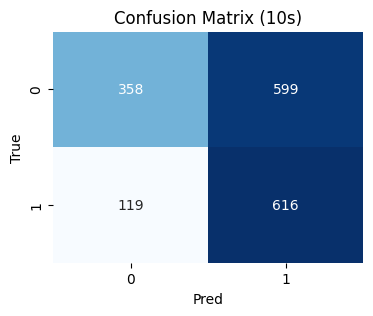

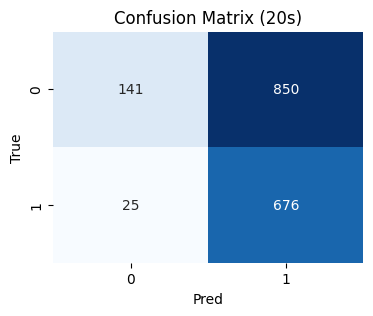

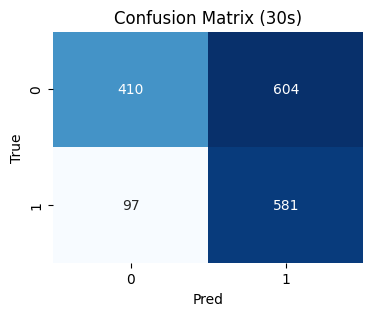


=== Epoch 2/5 ===


Train Loss=0.7219  |  Val Loss=0.6772
[10s] AUROC=0.772  AUPRC=0.731  F1=0.678  P=0.545  R=0.898  thr=0.43  Pos=735
[20s] AUROC=0.769  AUPRC=0.718  F1=0.663  P=0.580  R=0.772  thr=0.46  Pos=701
[30s] AUROC=0.779  AUPRC=0.725  F1=0.661  P=0.595  R=0.742  thr=0.63  Pos=678


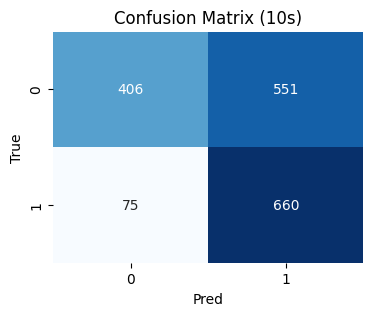

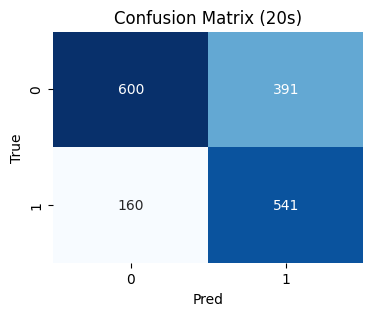

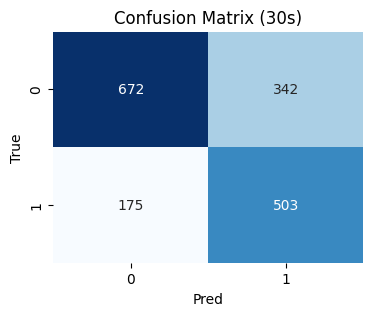


=== Epoch 3/5 ===


Train Loss=0.6122  |  Val Loss=0.6083
[10s] AUROC=0.850  AUPRC=0.797  F1=0.765  P=0.704  R=0.837  thr=0.57  Pos=735
[20s] AUROC=0.836  AUPRC=0.783  F1=0.724  P=0.655  R=0.809  thr=0.67  Pos=701
[30s] AUROC=0.848  AUPRC=0.785  F1=0.730  P=0.671  R=0.801  thr=0.68  Pos=678


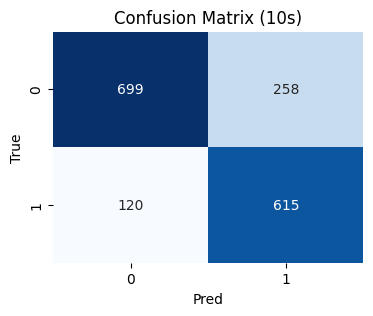

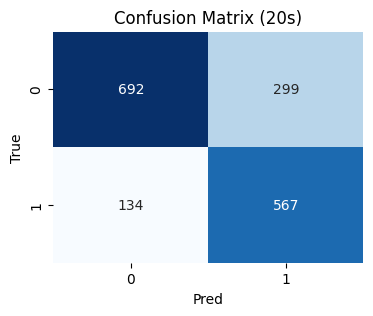

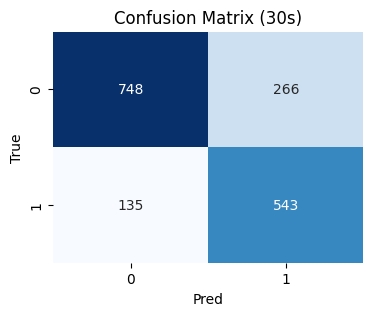


=== Epoch 4/5 ===


Train Loss=0.4954  |  Val Loss=0.5499
[10s] AUROC=0.896  AUPRC=0.859  F1=0.806  P=0.749  R=0.871  thr=0.49  Pos=735
[20s] AUROC=0.901  AUPRC=0.869  F1=0.804  P=0.753  R=0.862  thr=0.63  Pos=701
[30s] AUROC=0.857  AUPRC=0.802  F1=0.742  P=0.644  R=0.875  thr=0.69  Pos=678


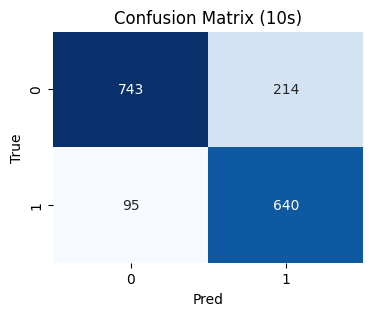

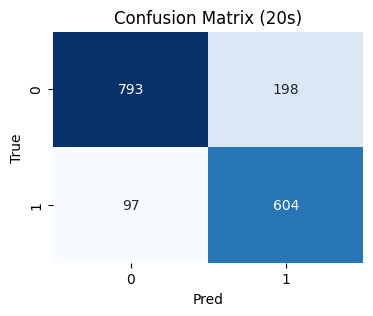

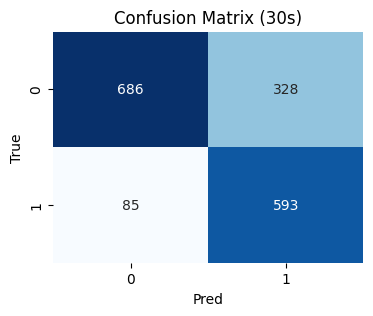


=== Epoch 5/5 ===


Train Loss=0.4005  |  Val Loss=0.4163
[10s] AUROC=0.922  AUPRC=0.889  F1=0.839  P=0.784  R=0.902  thr=0.69  Pos=735
[20s] AUROC=0.928  AUPRC=0.893  F1=0.831  P=0.741  R=0.944  thr=0.52  Pos=701
[30s] AUROC=0.936  AUPRC=0.894  F1=0.838  P=0.799  R=0.881  thr=0.57  Pos=678


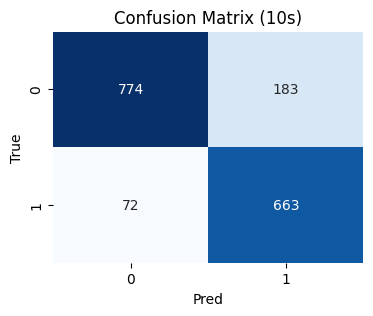

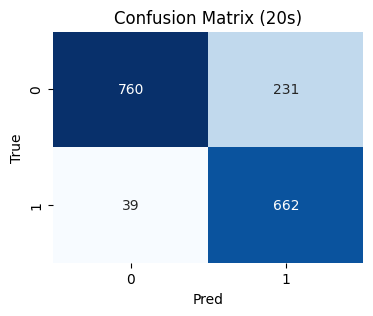

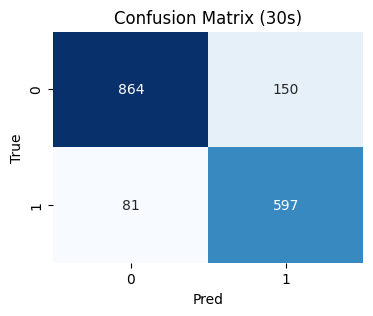

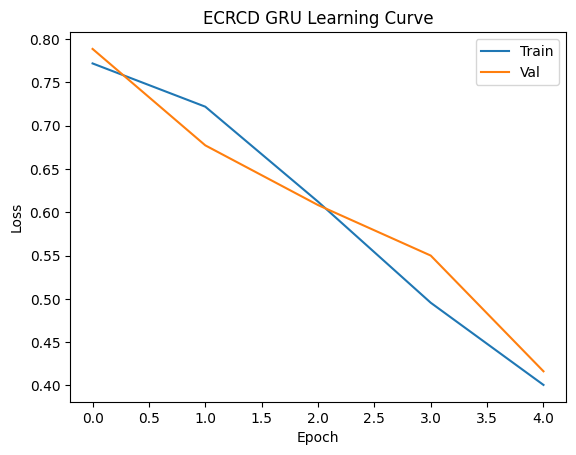

In [36]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

history = {"train": [], "val": []}
best_val = float("inf"); bad = 0; patience = 3

def run_eval(loader):
    model.eval(); Ys=[]; Ps=[]
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            prob = torch.sigmoid(model(X))
            Ys.append(y.cpu().numpy()); Ps.append(prob.cpu().numpy())
    if not Ys: return None
    return np.vstack(Ys), np.vstack(Ps)

def best_thresholds(y_true, y_prob):
    ths = []
    for i in range(y_true.shape[1]):
        P, R, T = precision_recall_curve(y_true[:, i], y_prob[:, i])
        f1 = (2*P*R)/(P+R+1e-9)
        ths.append(float(T[np.nanargmax(f1)]) if len(T) else 0.5)
    return ths

def eval_by_horizon(y_true, y_prob, ths):
    out, cms = {}, []
    names = ["10s","20s","30s"]
    for i, n in enumerate(names):
        t = y_true[:, i].astype(int)
        p = (y_prob[:, i] >= ths[i]).astype(int)
        out[n] = {
            "AUROC": roc_auc_score(t, y_prob[:, i]) if t.mean() not in [0,1] else np.nan,
            "AUPRC": average_precision_score(t, y_prob[:, i]) if t.sum()>0 else np.nan,
            "F1": f1_score(t, p, zero_division=0),
            "Precision": precision_score(t, p, zero_division=0),
            "Recall": recall_score(t, p, zero_division=0),
            "Threshold": ths[i],
            "Positives": int(t.sum())
        }
        cms.append(confusion_matrix(t, p))
    return out, cms

EPOCHS = 5
for ep in range(1, EPOCHS+1):
    print(f"\n=== Epoch {ep}/{EPOCHS} ===")
    model.train(); tot = 0.0
    for X, y in tqdm(train_loader, desc="Training", leave=False):
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tot += loss.item()
    train_loss = tot / max(1, len(train_loader))

    ev = run_eval(val_loader)
    if ev is None:
        print("No validation data available"); break
    y_true, y_prob = ev

    val_loss = 0.0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(DEVICE), yv.to(DEVICE)
            val_loss += criterion(model(Xv), yv).item()
    val_loss /= max(1, len(val_loader))
    scheduler.step(val_loss)

    history["train"].append(train_loss); history["val"].append(val_loss)
    print(f"Train Loss={train_loss:.4f}  |  Val Loss={val_loss:.4f}")

    ths = best_thresholds(y_true, y_prob)
    per_hz, cms = eval_by_horizon(y_true, y_prob, ths)
    for k, v in per_hz.items():
        print(f"[{k}] AUROC={v['AUROC']:.3f}  AUPRC={v['AUPRC']:.3f}  "
              f"F1={v['F1']:.3f}  P={v['Precision']:.3f}  R={v['Recall']:.3f}  "
              f"thr={v['Threshold']:.2f}  Pos={v['Positives']}")

    for i, name in enumerate(["10s","20s","30s"]):
        plt.figure(figsize=(4,3))
        sns.heatmap(cms[i], annot=True, fmt="d", cbar=False, cmap="Blues")
        plt.title(f"Confusion Matrix ({name})")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

plt.figure()
plt.plot(history["train"], label="Train")
plt.plot(history["val"], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("ECRCD GRU Learning Curve")
plt.legend()
plt.show()


In [37]:
import json
from pathlib import Path
import numpy as np

WORK_DIR = Path("/kaggle/working")
MODEL_PATH = WORK_DIR / "gru_ecrcd.pth"
FEATCFG_PATH = WORK_DIR / "ecrcd_feature_config.json"
TH_PATH = WORK_DIR / "ecrcd_thresholds.json"
METRICS_PATH = WORK_DIR / "ecrcd_val_metrics.json"

def eval_and_save(val_loader):
    model.eval()
    Ys, Ps = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            prob = torch.sigmoid(model(X))
            Ys.append(y.cpu().numpy()); Ps.append(prob.cpu().numpy())
    y_true, y_prob = np.vstack(Ys), np.vstack(Ps)

    
    def best_thresholds(y_true, y_prob):
        ths = []
        for i in range(y_true.shape[1]):
            P, R, T = precision_recall_curve(y_true[:, i], y_prob[:, i])
            f1 = (2*P*R)/(P+R+1e-9)
            ths.append(float(T[np.nanargmax(f1)]) if len(T) else 0.5)
        return ths

    ths = best_thresholds(y_true, y_prob)

    def by_hz(y_true, y_prob, ths):
        out = {}
        names = ["10s","20s","30s"]
        for i,n in enumerate(names):
            t = y_true[:,i].astype(int)
            p = (y_prob[:,i] >= ths[i]).astype(int)
            out[n] = {
                "AUROC": float(roc_auc_score(t, y_prob[:,i])) if t.mean() not in [0,1] else float("nan"),
                "AUPRC": float(average_precision_score(t, y_prob[:,i])) if t.sum()>0 else float("nan"),
                "F1": float(f1_score(t, p, zero_division=0)),
                "Precision": float(precision_score(t, p, zero_division=0)),
                "Recall": float(recall_score(t, p, zero_division=0)),
                "Threshold": float(ths[i]),
                "Positives": int(t.sum()),
            }
        return out, ths

    metrics, ths = by_hz(y_true, y_prob, ths)
    return metrics, ths

torch.save(model.state_dict(), MODEL_PATH)

feat_info = {
    "features": features,
    "window": 300,
    "fps": 25,
    "targets": ["y_10s","y_20s","y_30s"]
}
with open(FEATCFG_PATH, "w") as f:
    json.dump(feat_info, f, indent=2)

metrics, ths = eval_and_save(val_loader)
with open(TH_PATH, "w") as f:
    json.dump({"y_10s": ths[0], "y_20s": ths[1], "y_30s": ths[2]}, f, indent=2)
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:")
print("  •", MODEL_PATH)
print("  •", FEATCFG_PATH)
print("  •", TH_PATH)
print("  •", METRICS_PATH)


✅ Saved:
  • /kaggle/working/gru_ecrcd.pth
  • /kaggle/working/ecrcd_feature_config.json
  • /kaggle/working/ecrcd_thresholds.json
  • /kaggle/working/ecrcd_val_metrics.json


In [38]:
import json
import numpy as np
import torch



def make_sequences(df_feat, features, window=300):
    df_feat = df_feat.sort_values(["video_id","frame_n"]).reset_index(drop=True)
    Xs = []
    idx_map = []  # (video_id, frame_n) for the window end
    for start in range(0, len(df_feat)-window):
        end = start + window
        Xs.append(df_feat.loc[start:end-1, features].to_numpy(dtype=np.float32))
        idx_map.append((df_feat.loc[end-1, "video_id"], int(df_feat.loc[end-1, "frame_n"])))
    X = torch.tensor(np.stack(Xs, axis=0)) if Xs else torch.empty(0, window, len(features))
    return X, idx_map

def predict_on_df(df_new, model, features, window=300, device="cpu"):
    df_feat_new = build_features(df_new, fps=25)
    X, idx_map = make_sequences(df_feat_new, features, window)
    if len(X) == 0:
        return df_feat_new.assign(p10=np.nan, p20=np.nan, p30=np.nan)

    model.eval()
    with torch.no_grad():
        probs = []
        bs = 64
        for i in range(0, len(X), bs):
            xb = X[i:i+bs].to(device)
            pb = torch.sigmoid(model(xb)).cpu().numpy()
            probs.append(pb)
        probs = np.vstack(probs)

    out = pd.DataFrame(idx_map, columns=["video_id","frame_n"])
    out["p10"], out["p20"], out["p30"] = probs[:,0], probs[:,1], probs[:,2]
    return out
print("✅ Inference helpers ready")


✅ Inference helpers ready


In [40]:

import numpy as np

def fuse_probs(p_ecrcd: np.ndarray, p_cholec: np.ndarray, w_e: float = 0.5):
    assert p_ecrcd.shape == p_cholec.shape, "shape mismatch"
    return w_e * p_ecrcd + (1.0 - w_e) * p_cholec

def binarize_with_thresholds(p: np.ndarray, ths=(0.5,0.5,0.5)):
    return (p >= np.array(ths)[None, :]).astype(int)

print("✅ Fusion helpers ready")


✅ Fusion helpers ready
